1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


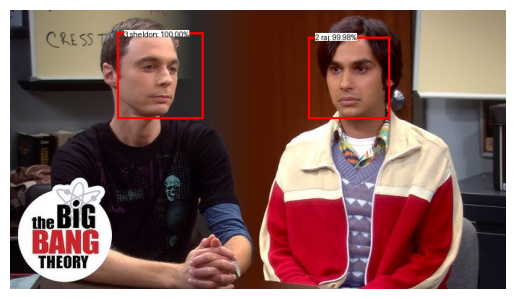

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
from keras.models import load_model
from keras.layers import DepthwiseConv2D as KerasDepthwiseConv2D
from keras import layers
from keras import backend as K
from PIL import Image, ImageOps, ImageDraw, ImageFont
import numpy as np
import cv2
import matplotlib.pyplot as plt  # Para exibição com matplotlib
from google.colab import files  # Para o download no Colab

# Caminhos dos arquivos
model_path = "/content/keras_model.h5"  # Substitua pelo caminho correto
labels_path = "/content/labels.txt"    # Substitua pelo caminho correto
image_path = "/content/image1.jpg"      # Substitua pelo caminho da imagem

# Redefinir a camada DepthwiseConv2D para ignorar o parâmetro 'groups'
class CustomDepthwiseConv2D(KerasDepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        # Remover o parâmetro 'groups' (se presente) para garantir a compatibilidade
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(*args, **kwargs)

# Função para carregar o modelo com a camada customizada
def custom_load_model(model_path):
    # Substituir a camada DepthwiseConv2D do Keras pela nossa versão customizada
    from keras.utils import get_custom_objects
    get_custom_objects()['DepthwiseConv2D'] = CustomDepthwiseConv2D

    # Carregar o modelo
    model = load_model(model_path, compile=False)
    return model

# Carregar o modelo com a camada customizada
model = custom_load_model(model_path)

# Carregar os rótulos
with open(labels_path, "r") as file:
    class_names = file.readlines()

# Função para redimensionar a face para o tamanho esperado pelo modelo (224x224)
def preprocess_face(face_image):
    face_image = Image.fromarray(face_image)
    face_image = ImageOps.fit(face_image, (224, 224), Image.Resampling.LANCZOS)
    face_array = np.asarray(face_image)
    face_array = (face_array.astype(np.float32) / 127.5) - 1
    return np.expand_dims(face_array, axis=0)

# Detecção de rosto usando OpenCV (Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Abrir a imagem original
image = Image.open(image_path).convert("RGB")
image_array = np.asarray(image)

# Convertendo a imagem original para escala de cinza (necessário para a detecção de rosto)
gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

# Ajustar parâmetros para reduzir falsos positivos e melhorar a detecção
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=7, minSize=(50, 50), flags=cv2.CASCADE_SCALE_IMAGE)

# Desenhar as caixas de rosto e os rótulos
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()  # Fonte padrão

# Definir um tamanho maior para os rótulos
try:
    font = ImageFont.truetype("arial", 30)  # Fonte maior para melhor legibilidade
except IOError:
    font = ImageFont.load_default()

# Verifique se algum rosto foi detectado
if len(faces) == 0:
    print("Nenhum rosto detectado.")

# Processar cada rosto detectado
for (x, y, w, h) in faces:
    # Cortar a face detectada da imagem
    face_image = image_array[y:y+h, x:x+w]

    # Preprocessar a face detectada
    face_data = preprocess_face(face_image)

    # Fazer a predição para o rosto individual
    prediction = model.predict(face_data)
    index = np.argmax(prediction)
    class_name = class_names[index].strip()  # Remove caracteres extras
    confidence_score = prediction[0][index]

    # Desenhar o retângulo ao redor do rosto com um pequeno buffer
    buffer = 10  # Um pequeno buffer para evitar que a caixa ultrapasse o limite da face
    draw.rectangle([x-buffer, y-buffer, x + w+buffer, y + h+buffer], outline="red", width=3)

    # Posicionar o rótulo um pouco acima do rosto
    label = f"{class_name}: {confidence_score*100:.2f}%"

    # Usar textbbox para calcular as dimensões do rótulo
    bbox = draw.textbbox((0, 0), label, font=font)
    label_width = bbox[2] - bbox[0]
    label_height = bbox[3] - bbox[1]

    # Ajustar a posição do rótulo para que não ultrapasse os limites da imagem
    label_x = max(x, 0)
    label_y = max(y - label_height - 5, 0)

    # Desenhar o fundo branco atrás do texto (para melhorar a legibilidade)
    draw.rectangle([label_x, label_y, label_x + label_width, label_y + label_height], fill="white")

    # Desenhar o rótulo em cima do fundo branco
    draw.text((label_x, label_y), label, fill="black", font=font)

# Salvar a imagem com as marcações
output_image_path = "/content/marked_image_with_background.jpg"
image.save(output_image_path)

# Exibir a imagem com as marcações
plt.imshow(image)
plt.axis('off')  # Esconder os eixos
plt.show()

# Baixar a imagem com as marcações
files.download(output_image_path)